**Crop Disease Model**

In [39]:
# ✅ 1. Setup
!rm -rf agrix_beta_2025
!git clone https://github.com/smwaingeni-ai/agrix_beta_2025.git
!ls agrix_beta_2025/assets/crops

!pip install tensorflow matplotlib seaborn --quiet


Cloning into 'agrix_beta_2025'...
remote: Enumerating objects: 1899, done.
remote: Counting objects: 100% (245/245), done.
remote: Compressing objects: 100% (208/208), done.
remote: Total 1899 (delta 89), reused 37 (delta 37), pack-reused 1654 (from 1)
Receiving objects: 100% (1899/1899), 44.50 MiB | 28.46 MiB/s, done.
Resolving deltas: 100% (896/896), done.
Healthy  Maize___Leaf_Spot  Tomato___Bacterial_spot


**1. Important Libraries**

In [40]:
# ✅ 2. Imports/Libraries
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


**2. Constraints**

In [41]:
# ✅ 3. Constants
DATA_DIR = "/content/agrix_beta_2025/assets/crops"
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 50
MODEL_NAME = "crop_disease_model.h5"
TFLITE_NAME = "crop_disease_model.tflite"
LABEL_FILE = "crop_labels.txt"

**3. Helper Functions**

In [42]:
# ✅ 4. Helper Functions

def load_classes(data_dir):
    data_dir = pathlib.Path(data_dir)
    return sorted([f.name for f in data_dir.glob("*") if f.is_dir()])

def create_generators(data_dir, image_size, batch_size):
    datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2,
        rotation_range=25,
        zoom_range=0.3,
        shear_range=0.25,
        horizontal_flip=True
    )
    train_gen = datagen.flow_from_directory(
        data_dir, target_size=image_size, batch_size=batch_size,
        class_mode='categorical', subset='training')
    val_gen = datagen.flow_from_directory(
        data_dir, target_size=image_size, batch_size=batch_size,
        class_mode='categorical', subset='validation', shuffle=False)
    return train_gen, val_gen


**5. Model Build**

In [43]:
# ✅ 5. Model Build

def build_model(num_classes):
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=IMAGE_SIZE + (3,),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = True
    for layer in base_model.layers[:-50]:
        layer.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)
    model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])
    return model


**6. Model Training**

In [44]:
# ✅ 6. Train Model

def train_model(model, train_gen, val_gen):
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6)

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=EPOCHS,
        callbacks=[early_stop, reduce_lr]
    )
    return history


**7. Model Evaluation**

In [45]:
# ✅ 7. Evaluate Model

def evaluate_model(model, val_gen):
    y_probs = model.predict(val_gen)
    y_pred = np.argmax(y_probs, axis=1)
    y_true = val_gen.classes

    acc = accuracy_score(y_true, y_pred)
    print(f"✅ Accuracy: {acc:.4f}\n")

    print("📋 Classification Report:")
    print(classification_report(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=val_gen.class_indices.keys(),
                yticklabels=val_gen.class_indices.keys())
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


**8. Save Model**

In [46]:
# ✅ 8. Save Model

def save_model_and_labels(model, label_file, tflite_name, model_name, class_names):
    model.save(model_name)
    print(f"✅ Saved model to {model_name}")

    # TFLite
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    tflite_model = converter.convert()

    with open(tflite_name, "wb") as f:
        f.write(tflite_model)
    print(f"✅ Exported to {tflite_name}")

    # Labels
    with open(label_file, "w") as f:
        for label in class_names:
            f.write(f"{label}\n")
    print(f"✅ Saved labels to {label_file}")


**9. Execution**

Found 256 images belonging to 3 classes.
Found 63 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
 1/16 ━━━━━━━━━━━━━━━━━━━━ 6:58 28s/step - accuracy: 0.1875 - loss: 2.8868

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


16/16 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.4964 - loss: 2.3721 - val_accuracy: 0.3810 - val_loss: 5.2756 - learning_rate: 0.0010
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8016 - loss: 1.7666 - val_accuracy: 0.5873 - val_loss: 2.8300 - learning_rate: 0.0010
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9005 - loss: 1.5163 - val_accuracy: 0.6190 - val_loss: 2.4541 - learning_rate: 0.0010
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8979 - loss: 1.3826 - val_accuracy: 0.4444 - val_loss: 3.9899 - learning_rate: 0.0010
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.9819 - loss: 1.1725 - val_accuracy: 0.4921 - val_loss: 3.9329 - learning_rate: 0.0010
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9648 - loss: 1.1024 - val_accuracy: 0.4921 - val_loss: 3.5723 - learning_rate: 0.0010
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9875 - loss: 0.9988 - val_accuracy: 0.5873 - va

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step
✅ Accuracy: 0.6032

📋 Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.80      0.63        20
           1       0.63      0.77      0.69        22
           2       1.00      0.24      0.38        21

    accuracy                           0.60        63
   macro avg       0.72      0.60      0.57        63
weighted avg       0.72      0.60      0.57        63



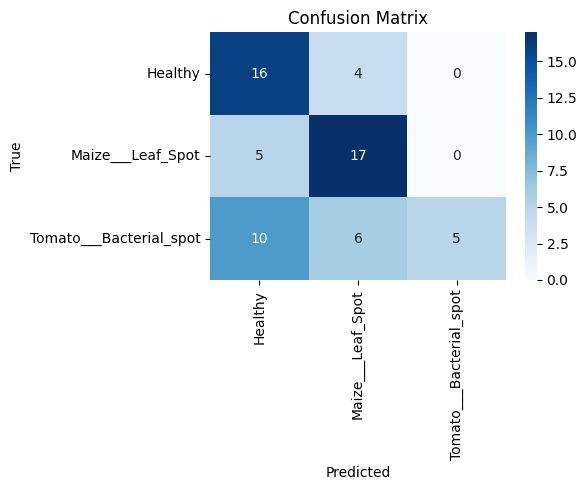

✅ Saved model to crop_disease_model.h5
Saved artifact at '/tmp/tmp3g3px8d3'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_1434')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  134510461533072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134510461526736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134510461526928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134510461532880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134510461531152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134510461528272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134510461528080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134510461527312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134510461527888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134510461530768: TensorSpec(shape=(), dt

In [47]:
# ✅ 9. Execute Full Pipeline

# Load class names
class_names = load_classes(DATA_DIR)

# Generators
train_gen, val_gen = create_generators(DATA_DIR, IMAGE_SIZE, BATCH_SIZE)

# Build model
model = build_model(len(class_names))

# Train
history = train_model(model, train_gen, val_gen)

# Evaluate
evaluate_model(model, val_gen)

# Save
save_model_and_labels(model, LABEL_FILE, TFLITE_NAME, MODEL_NAME, class_names)
